# Fine-Tune CNN for Cats-Dogs Classification
### Fine-tune VGG16 top layers (conv block 5) and top-level fully connected classifier to classify images of cats and dogs.  
#### Adapted from fchollet/classifier_from_little_data_script_3.py (https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975) and blog https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


In [17]:
import keras

In [18]:
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
# from keras.layers import Conv2D, MaxPooling2D
# from keras import backend as K

# import h5py
import numpy as np

In [19]:
import tensorflow as tf
print (tf.__version__)
print (keras.__version__)

1.14.0
2.2.4


In [20]:
# Set logging level
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [21]:
# Set random generator seed

seed = 123
np.random.seed(seed)

from tensorflow import set_random_seed
set_random_seed(246)

### Set location, number, and dimensions of images 

In [22]:
# Location of images
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

# Number of images
nb_train_samples = 2000
nb_validation_samples = 800

# Image dimensions
img_width, img_height = 150, 150

### Load pre-trained CNN

In [23]:
# Load VGG16 network's imagenet weights, not including last fully connected block
base_model = applications.VGG16 (weights='imagenet', include_top=False, 
                            input_shape=(img_width,img_height,3))
print ('Model loaded')
base_model.summary()

Model loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0       

### Create classifier to put on top of CNN and load its weights (from features notebook)

In [24]:
# Create fully connected layer as top model for CNN base
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))  # Convert 3D feature maps to 1D feature vectors
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# Load classifier's weights
top_model_weights = 'features_model-wts.h5'
top_model.load_weights (top_model_weights)

# Add classifier on top of CNN base
# model.add (top_model)
model = Model (inputs=base_model.input, outputs=top_model(base_model.output))

# Freeze weights in CNN up to last Conv block
for layer in model.layers[:15]:
    layer.trainable = False

# Compile model with SGD optimizer with momentum and very slow learning rate
model.compile(optimizer=optimizers.SGD (lr=1e-4, momentum=0.9),
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Prepare data

In [25]:
# Set batch size
batch_size = 16

# Data augmentation setup
train_datagen = ImageDataGenerator (
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2, 
    horizontal_flip = True)
test_datagen = ImageDataGenerator (
    rescale = 1. / 255)

# Set up generator to read images found in subfolders of training data directory,
# and indefinitely generate batches of image data (scaled).  This is for training data.
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',    
    seed=seed)                # Set seed for reproducibility

# Set up generator to generate batched of validation data for model
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    seed=seed,
    shuffle=False)
 

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [26]:
results = model.evaluate_generator(train_generator, steps=nb_train_samples // batch_size)
print (results)
results = model.evaluate_generator(validation_generator, steps=nb_validation_samples // batch_size)
print (results)

[0.497273444639267, 0.938]
[1.012942109122021, 0.88875]


### Fine tune model

In [27]:
# Set number of training epochs
epochs = 5

# Train model, keeping track of history
from keras.callbacks import History
hist = model.fit_generator(
    train_generator, 
    steps_per_epoch = nb_train_samples // batch_size,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size,
    initial_epoch=0,
    verbose = 2)

Epoch 1/5
 - 17s - loss: 0.6782 - acc: 0.7980 - val_loss: 0.2827 - val_acc: 0.8950
Epoch 2/5
 - 16s - loss: 0.2261 - acc: 0.9105 - val_loss: 0.2565 - val_acc: 0.9225
Epoch 3/5
 - 16s - loss: 0.1778 - acc: 0.9305 - val_loss: 0.2576 - val_acc: 0.9275
Epoch 4/5
 - 18s - loss: 0.1393 - acc: 0.9455 - val_loss: 0.2322 - val_acc: 0.9225
Epoch 5/5
 - 16s - loss: 0.1068 - acc: 0.9585 - val_loss: 0.2545 - val_acc: 0.9237


In [28]:
results = model.evaluate_generator(train_generator, steps=nb_train_samples // batch_size)
print (results)
results = model.evaluate_generator(validation_generator, steps=nb_validation_samples // batch_size)
print (results)

[0.081926572737284, 0.9705]
[0.25445707581937316, 0.92375]


### Save model and weights

In [29]:
# Save model & weights to HDF5 file
model_file = 'finetune' 
model.save(model_file + '.h5')

# Save model to JSON file & weights to HDF5 file
model_json = model.to_json()
with open(model_file + '.json','w') as json_file:
    json_file.write(model_json)
model.save_weights(model_file+'-wts.h5')

# Results on validation set
print (model.metrics_names)
results = model.evaluate_generator(validation_generator, steps=nb_validation_samples // batch_size)
print (results)

['loss', 'acc']
[0.25445707581937316, 0.92375]


### Load model again and test

In [30]:
model2 = keras.models.load_model(model_file+'.h5')

print (model2.metrics_names)
results = model.evaluate_generator(validation_generator, steps=nb_validation_samples // batch_size)
print (results)
# scores = model2.evaluate_generator(validation_generator)

['loss', 'acc']
[0.25445707581937316, 0.92375]


### Print training history

In [31]:
print (hist.history)

{'val_loss': [0.28268648833036425, 0.25649285726249216, 0.25764255326241253, 0.23215294498950242, 0.25445707581937316], 'val_acc': [0.895, 0.9225, 0.9275, 0.9225, 0.92375], 'loss': [0.6782166837358382, 0.22605130375921725, 0.17781168530369176, 0.13933361012022943, 0.10681971443700604], 'acc': [0.798, 0.9105, 0.9305, 0.9455, 0.9585]}


### Plot performance metrics

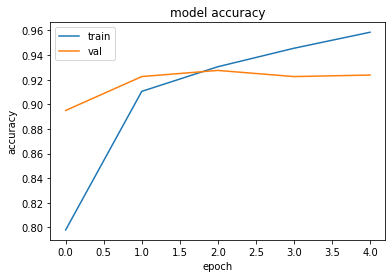

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

result = hist.history

# summarize history for accuracy
plt.plot(result['acc'])
plt.plot(result['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()